In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNN_ResNet50_FPN_Weights
from dataset_loader.dataset import DatasetConfig, ObjectDetectionDataset  # Asegúrate de que estén en el mismo directorio o en el PATH
from torchvision.ops import box_iou
from torchsummary import summary
from torchinfo import summary



In [2]:

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando {device}")

# Configuración del Dataset
dataset_config = DatasetConfig(
    img_width=1792, 
    img_height=1434,
    dataset_path="../../data_maskrcnn/dataset_hst",  # Cambia esta ruta por la de tu dataset
    splits=["train_data", "val_data"]
)

# Crear DataLoaders para entrenamiento y validación
train_dataset = ObjectDetectionDataset(config=dataset_config, split="train_data", is_train=True)
val_dataset = ObjectDetectionDataset(config=dataset_config, split="val_data", is_train=False)

# DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=4, 
    shuffle=True, 
    collate_fn=lambda x: tuple(zip(*x))  # Agrupa las imágenes y etiquetas en listas
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=4, 
    shuffle=False, 
    collate_fn=lambda x: tuple(zip(*x))
)

Usando cuda


In [3]:

# Cargar modelo Mask R-CNN solo para detección de objetos
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = maskrcnn_resnet50_fpn(weights=weights)
model.roi_heads.mask_predictor = None  # Remover la cabeza de predicción de máscaras

# Número de clases (incluye la clase fondo)
num_classes = 4 # 3 clases más la clase fondo
in_features = model.roi_heads.box_predictor.cls_score.in_features
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# Ajustar el umbral de puntuación
model.roi_heads.score_thresh = 0.5
# print(model.roi_heads.score_thresh)

# Cargar pesos personalizados si corresponde
try:
    model.load_state_dict(torch.load("custom_maskrcnn.pt"))
    print("Pesos personalizados cargados con éxito.")
except FileNotFoundError:
    print("No se encontró el archivo de pesos personalizados. Usando pesos preentrenados.")

model.to(device)
print('')

C:\Users\santi\AppData\Local\Temp\ipykernel_1108944\2985148218.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("custom_maskrcnn.pt"))


Pesos personalizados cargados con éxito.



In [4]:
# print(targets)

# model(images, targets)  # Forward pass

In [5]:
# summary(model, input_size=(1, 3, 224, 224))

In [6]:
from torchvision.ops import box_iou

def evaluate_model(model, data_loader, device):
    model.eval()
    iou_thresholds = torch.linspace(0.5, 0.95, steps=10).to(device)
    metrics = {"mAP": 0.0, "mAP_50": 0.0}
    mAP_scores = []

    with torch.no_grad():
        for images, targets in data_loader:
            # Mover imágenes al dispositivo
            images = [img.to(device) for img in images]

            # Obtener predicciones del modelo
            outputs = model(images)

            for output, target in zip(outputs, targets):
                # Manejo de predicciones vacías
                if len(output["boxes"]) == 0:
                    continue

                # Mover predicciones y targets al dispositivo
                pred_boxes = output["boxes"].to(device)
                pred_labels = output["labels"].to(device)
                true_boxes = target["boxes"].to(device)
                true_labels = target["labels"].to(device)

                # Calcular IoUs
                ious = box_iou(pred_boxes, true_boxes)
                if ious is None:
                    print('ious is None')
                # print(ious)
                # # Calcular mAP para cada umbral de IoU
                # for iou_threshold in iou_thresholds:
                #     if ious.numel() > 0:  # Evitar casos donde no hay IoUs calculables
                #         mAP_scores.append((ious > iou_threshold).float().mean().item())

                if ious.numel() > 0:  # Evita problemas con batches sin predicciones
                    metrics["mAP_50"] += (ious > 0.5).float().mean().item() 


        # Normalizar métricas
        if len(data_loader.dataset) > 0:
            metrics["mAP_50"] /= len(data_loader.dataset)
            # metrics["mAP"] = sum(mAP_scores) / len(iou_thresholds)
    print(metrics)
    return metrics


In [7]:
for param in model.parameters():
    # param.requires_grad = False
    param.requires_grad = True
    
# for name, param in model.named_parameters():
#     if "roi_heads.box_predictor.cls_score" in name or "roi_heads.box_predictor.bbox_pred" in name:
#         param.requires_grad = True
#     elif "roi_heads.box_head" in name:
#         param.requires_grad = True
#     elif "rpn.head" in name:
#         param.requires_grad = True
#     # elif "backbone.fpn.layer_blocks.3.0" in name:
#     #     param.requires_grad = True
#     # elif "backbone.body.layer4" in name:
#     #     param.requires_grad = True
#     else:
#         param.requires_grad = False

In [8]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

backbone.body.conv1.weight True
backbone.body.layer1.0.conv1.weight True
backbone.body.layer1.0.conv2.weight True
backbone.body.layer1.0.conv3.weight True
backbone.body.layer1.0.downsample.0.weight True
backbone.body.layer1.1.conv1.weight True
backbone.body.layer1.1.conv2.weight True
backbone.body.layer1.1.conv3.weight True
backbone.body.layer1.2.conv1.weight True
backbone.body.layer1.2.conv2.weight True
backbone.body.layer1.2.conv3.weight True
backbone.body.layer2.0.conv1.weight True
backbone.body.layer2.0.conv2.weight True
backbone.body.layer2.0.conv3.weight True
backbone.body.layer2.0.downsample.0.weight True
backbone.body.layer2.1.conv1.weight True
backbone.body.layer2.1.conv2.weight True
backbone.body.layer2.1.conv3.weight True
backbone.body.layer2.2.conv1.weight True
backbone.body.layer2.2.conv2.weight True
backbone.body.layer2.2.conv3.weight True
backbone.body.layer2.3.conv1.weight True
backbone.body.layer2.3.conv2.weight True
backbone.body.layer2.3.conv3.weight True
backbone.bo

In [9]:
# optimizer = torch.optim.SGD([param for param in model.parameters() if param.requires_grad], 
#                             lr=0.001, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.SGD([param for param in model.parameters() if param.requires_grad], 
                            lr=0.01, momentum=0.9, weight_decay=0.00001)
# mejor es lr=0.01 y weight_decay=0.0005
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [10]:
# Entrenamiento
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    print(f"Epoch {epoch + 1}/{num_epochs}")
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Adelanto y cálculo de pérdidas
        loss_dict = model(images, targets)
        losses = sum(loss for key, loss in loss_dict.items() if key != "loss_mask")
        epoch_loss += losses.item()

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        # print(f"Loss: {losses.item()}")

    # Actualización del scheduler
    lr_scheduler.step()

    # Evaluación
    metrics = evaluate_model(model, val_loader, device)

    # print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Loss: {epoch_loss:.4f}")
    print(f"Validation mAP@50: {metrics['mAP_50']:.4f}")
    # print(f"Validation mAP: {metrics['mAP']}")



Epoch 1/100
{'mAP': 0.0, 'mAP_50': 0.4414768866870714}
Loss: 17.0641
Validation mAP@50: 0.4415
Epoch 2/100
{'mAP': 0.0, 'mAP_50': 0.4185300255599229}
Loss: 10.4212
Validation mAP@50: 0.4185
Epoch 3/100
{'mAP': 0.0, 'mAP_50': 0.44939958984437195}
Loss: 8.1807
Validation mAP@50: 0.4494
Epoch 4/100
{'mAP': 0.0, 'mAP_50': 0.4511387199163437}
Loss: 6.4731
Validation mAP@50: 0.4511
Epoch 5/100
{'mAP': 0.0, 'mAP_50': 0.4511387199163437}
Loss: 5.6058
Validation mAP@50: 0.4511
Epoch 6/100
{'mAP': 0.0, 'mAP_50': 0.4583850962960202}
Loss: 5.3523
Validation mAP@50: 0.4584
Epoch 7/100
{'mAP': 0.0, 'mAP_50': 0.4583850962960202}
Loss: 5.0535
Validation mAP@50: 0.4584
Epoch 8/100
{'mAP': 0.0, 'mAP_50': 0.4583850962960202}
Loss: 4.9644
Validation mAP@50: 0.4584
Epoch 9/100
{'mAP': 0.0, 'mAP_50': 0.4583850962960202}
Loss: 4.8072
Validation mAP@50: 0.4584
Epoch 10/100
{'mAP': 0.0, 'mAP_50': 0.4583850962960202}
Loss: 4.8553
Validation mAP@50: 0.4584
Epoch 11/100
{'mAP': 0.0, 'mAP_50': 0.4583850962960202}


In [22]:
# # Guardar el modelo reentrenado
torch.save(model.state_dict(), "retrained_maskrcnn.pt")
print("Modelo guardado en 'retrained_maskrcnn.pt'")


Modelo guardado en 'retrained_maskrcnn.pt'


Predicción: 3
Predicción: 3
Predicción: 3
Predicción: 3


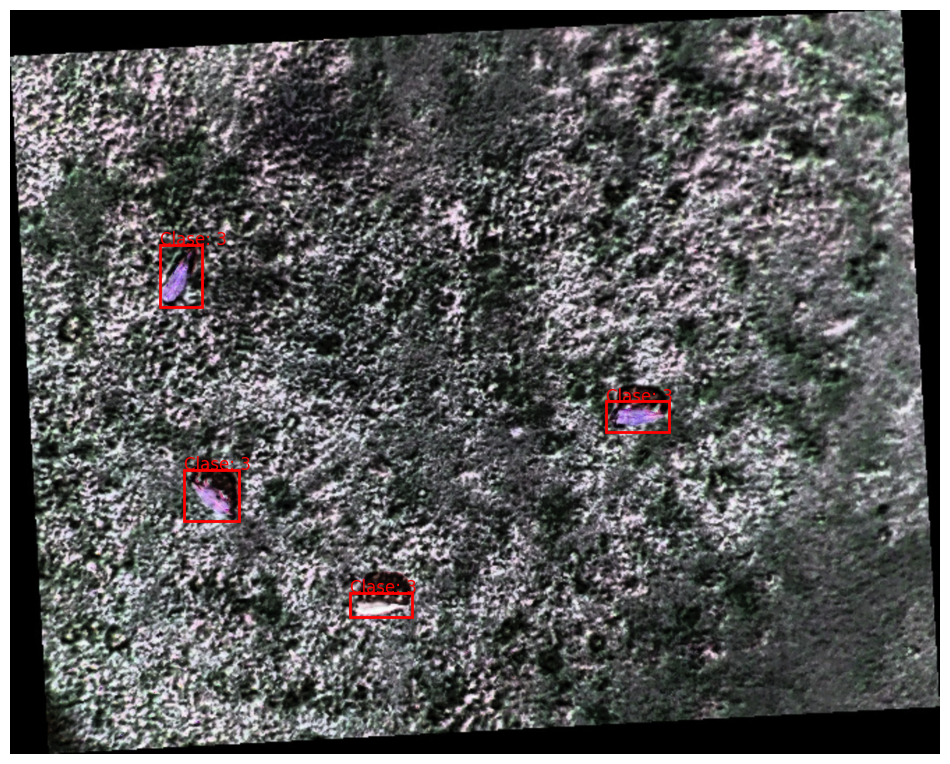

In [18]:
#do a forward pass and plot images with predicted bounding boxes
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T
from PIL import Image

def plot_image_with_boxes(img, target):
    img = img.mul(255).permute(1, 2, 0).byte().numpy()
    plt.figure(figsize=(12, 12))
    plt.imshow(img)

    for box, label in zip(target["boxes"], target["labels"]):
        box = box.int().cpu().numpy()
        x_min ,y_min, x_max, y_max = box
        #desnormalizar
        img_width, img_height = img.shape[1], img.shape[0]
        # print(img_width, img_height)
        # x_min = x_min * img_width
        # x_max = x_max * img_width
        # y_min = y_min * img_height
        # y_max = y_max * img_height

        #print predictions
        print(f"Predicción: {label.item()}")
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, edgecolor="r", lw=2))
        #add label
        plt.text(x_min, y_min, f"Clase: {label.item()}", color="r", fontsize=12)

    plt.axis("off")
    plt.show()

# Get a batch of images from the dataloader
images, targets = next(iter(train_loader))
images = [img.to(device) for img in images]

# Forward pass
model.eval()
with torch.no_grad():
    outputs = model(images)

#print bounding boxes
random_index = 1
# Plot first image with predicted bounding boxes
plot_image_with_boxes(images[random_index].cpu(), outputs[random_index])
